In [13]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import data_gen as dg

import torch
import geomloss
import matplotlib.pyplot as plt

# we continue with the second case

In [14]:
def langevin_step(samples, theta, eps):

    mu, var = theta[0], theta[1]
    noise = torch.randn_like(samples)
    grad_V = (samples - mu) / var

    return samples - eps * grad_V + torch.sqrt(torch.tensor(2 * eps)) * noise

In [15]:
def evolve_langevin(samples, theta, eps=1e-2, n_evolution=1000, seed=0):
    
    torch.manual_seed(seed)
    samples_evolved = samples.clone()

    for i in range(n_evolution):
        samples_evolved = langevin_step(samples_evolved, theta, eps)

    return samples_evolved

In [16]:
sinkhorn_loss = geomloss.SamplesLoss(loss="sinkhorn", p=2, blur=0.05)

def lm_loss(samples, theta):

    evolved_samples = evolve_langevin(samples, theta)
    if samples.ndim == 1:
        samples = samples.unsqueeze(1)
    if evolved_samples.ndim == 1:
        evolved_samples = evolved_samples.unsqueeze(1)

    return sinkhorn_loss(samples, evolved_samples)

In [17]:
def plot_distributions(samples, evolved):
    samples_np = samples.detach().cpu().numpy().flatten()
    evolved_np = evolved.detach().cpu().numpy().flatten()
    
    plt.figure(figsize=(6, 4))
    plt.hist(samples_np, bins=50, alpha=0.5, label='Original', density=True)
    plt.hist(evolved_np, bins=50, alpha=0.5, label='Evolved', density=True)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [18]:
def lm_optimize(samples, n_epochs=300, lr=1e-2):

    theta = torch.tensor([0.0, 1.0], requires_grad=True)

    optimizer = torch.optim.Adam([theta], lr=lr)

    for t in range(n_epochs):
        optimizer.zero_grad()
        loss = lm_loss(samples, theta)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            theta[1].clamp_(min=1e-3)

        if t % 100 == 0:
            mu_val = theta[0].item()
            var_val = theta[1].item()
            print(f"step {t} | loss = {loss.item():.6f} | mu = {mu_val:.4f} | var = {var_val:.4f}")
            evolved_samples = evolve_langevin(samples, theta)
            plot_distributions(samples, evolved_samples)

    return theta.detach()

step 0 | loss = 50.514465 | mu = 0.5000 | var = 1.5000


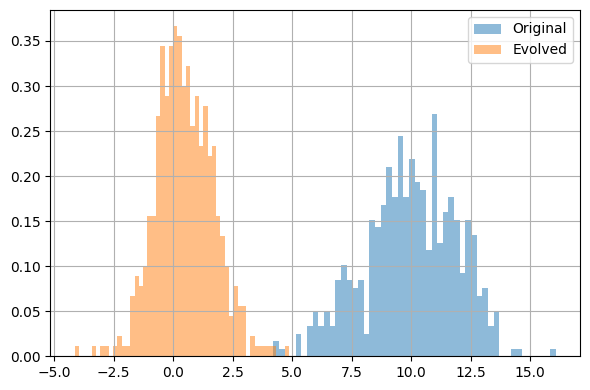

step 100 | loss = 0.137963 | mu = 10.0117 | var = 6.1028


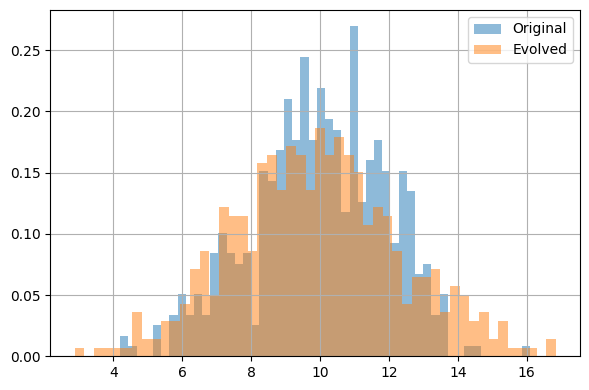

step 200 | loss = 0.006701 | mu = 10.0092 | var = 3.7128


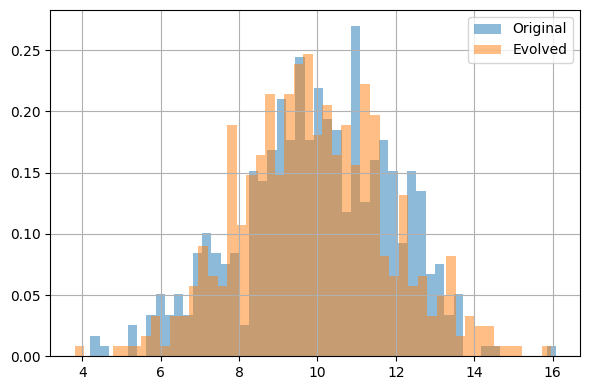

step 300 | loss = 0.006796 | mu = 10.0087 | var = 3.7034


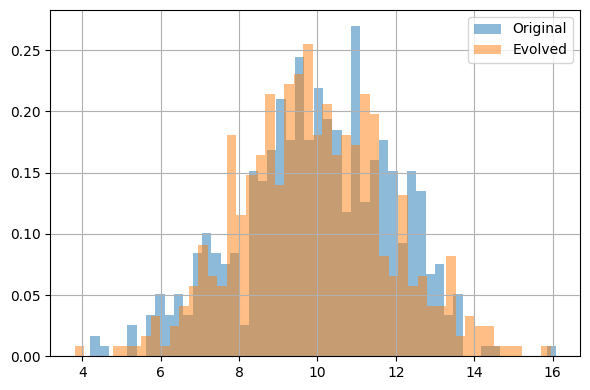

step 400 | loss = 0.006797 | mu = 10.0087 | var = 3.7034


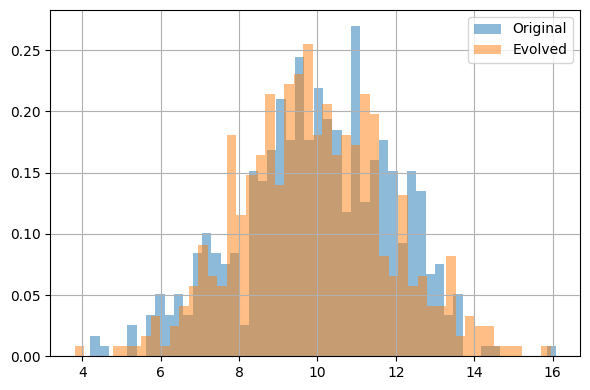

step 500 | loss = 0.006797 | mu = 10.0087 | var = 3.7034


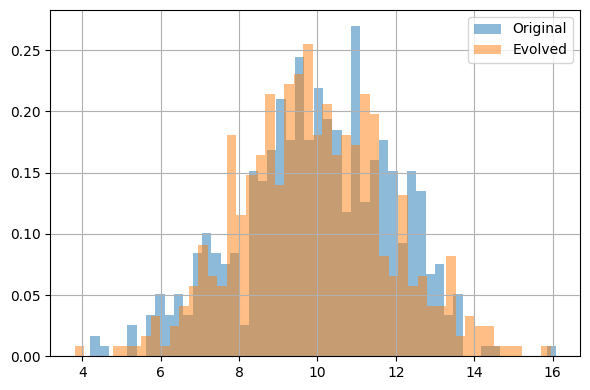

KeyboardInterrupt: 

In [19]:
true_mu, true_std = 10.0, 2.0
samples = torch.randn(500) * true_std + true_mu

theta_hat = lm_optimize(samples, n_epochs=5000, lr=0.5)

print(f"final mean:     {theta_hat[0].item():.4f}")
print(f"final variance:  {theta_hat[1].item():.4f}")